In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd


from rBoltzMach import boltzmanmachine
from metrics import pair_error, sequence_error, JS_divergence, p
from Graphics import distr_ami

plt.rcParams['font.size'] = 14

## Data selection

In [2]:
CASE=1           #select the data to be analysed
if CASE==0: dname="DATA"
if CASE==1: dname="DATA_b"
    
fname=dname+'/x_RBM_q0.1.dat'
v = np.loadtxt(fname, delimiter=" ",dtype=int)
v0 = np.copy(v)  #Copy original data to analyse later

In [3]:
perror = pair_error(v0, spin=False)
serror = sequence_error(v0, spin=False, vmin=0)
print(perror, serror)


9.457500000000001 22.6


## Network parameters

In [4]:
N = len(v)       #Number of rows
L = len(v[0])    #Set the number of visible variable
M = 6            #Set the number of hidden units

sigma = np.sqrt(4. / float(L + M))

print(f'each of N={N} data has L={L} digits')
print(f'The network has {L} visible units and {M} hidden units')
print(f'Initializing std {sigma}')

each of N=10000 data has L=20 digits
The network has 20 visible units and 6 hidden units
Initializing std 0.3922322702763681


## Load the Restricted Boltzmann Machine model 

In [5]:
file_name = 'Models/'+'RMSprop_005_1_spin.npz'
# np.random.seed(seed)
rbm = boltzmanmachine(L,M,sigma)
rbm.load_model(file_name)

## Generating fantasy data in order to test the model

In [6]:
Amp_gen = 0.5 #Setting the amplitude for generating data
vf = rbm.gen_fantasy(v0, Amp_gen)

## Evaluating Pair-wise errors, Sequence error, Jensen-Shannon Divergence

### Estimating the errors on the training dataset

In [7]:
perror0 = pair_error(vf, spin=True)
serror0 = sequence_error(vf, spin=True, vmin=-1)
print(f'v0 pair-wise error = {perror0} ')
print(f'v0 sequence error = {serror0} ')

v0 pair-wise error = 0.4075 
v0 sequence error = 0.81 


In [8]:
p = np.reshape(p(vf), (5,4))  #matrix that contain the instances of every possible state for each amminoacid
q = np.ones((5,4))*0.25       #target states distribution

In [9]:
print(p)
print(q)

[[0.1952 0.3149 0.4474 0.0425]
 [0.4806 0.0159 0.0766 0.4269]
 [0.4916 0.015  0.0562 0.4372]
 [0.484  0.0099 0.0248 0.4813]
 [0.0064 0.502  0.0202 0.4714]]
[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]


### Estimating the differences between the states distribution via JS divergence

In [10]:
JS_divergence(p,q)

0.6347251957867277

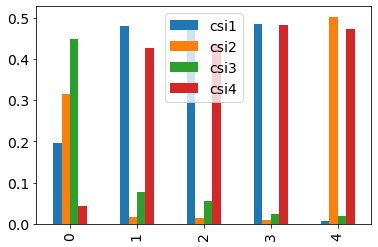

In [11]:
distr_ami(vf, 'test.png')